### Based on the insurance dataset taken from kaggle this script builds and trains a model to predict yearly health costs.

In [115]:
#Import required packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
import joblib

In [8]:
#Set directory and download dataset
os.chdir('C:/Users/xeb15154/OneDrive - University of Strathclyde/Data Science Projects/Hyperexponential Project/')
df = pd.read_csv('insurance.csv')
print(df.head())
print(df.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
(1338, 7)


### Data Information:
- Age: age of primary beneficiary (male = 0, female = 1, after transformation below)
    
- Sex: insurance contractor gender, female, male
    
- BMI: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
  objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- Children: Number of children covered by health insurance / Number of dependents

- Smoker: Individual (no = 0, yes = 1, after transformation below)

- Region: the beneficiarys residential area in the US,southeast (0), southwest (1), northeast (3), northwest (4) 

- Charges: Individual medical costs billed by health insurance

In [9]:
#Datset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
#datset descriptive statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [12]:
#Checking for nulls
missing_data = df[df.isna()]
missing_data.count()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [15]:
#checking for duplicates in the sample
print('Original Sample Size', df.shape)
print('Number of duplicated rows',df.duplicated().sum())
print('Duplicated rows',df[df.duplicated()])
#Remove duplicates
df = df.drop_duplicates()
print('New Sample Size', df.shape)

Original Sample Size (1338, 7)
Number of duplicated rows 1
Duplicated rows      age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631
New Sample Size (1337, 7)


In [17]:
#Validate categorical variables
print(df["smoker"].unique())
print(df["region"].unique())

['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


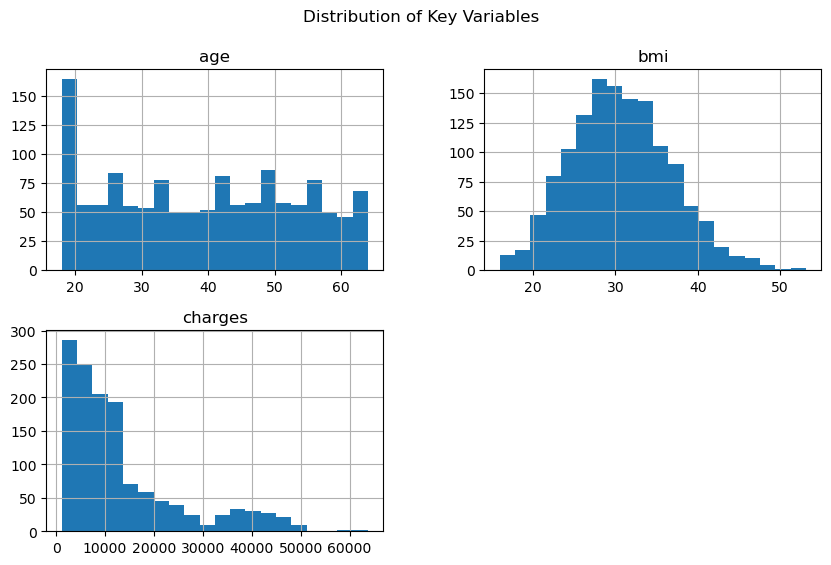

In [20]:
#evaluate variable distributions
df.hist(column=['age','bmi','charges'], bins=20, figsize=(10,6))
plt.suptitle("Distribution of Key Variables")
plt.show()

#### In the above histograms the variable age looks to have a flat distribution with a spike towards the left of the chart. This indicates that there is a larger quantity of younger participants associated with this sample (<20) with a fairly uniform distribution for the rest of the ages (20-60). The BMI variable looks to return a fairly normal distribution. However, the target variable (charges) looks to have a long tail indicating the data is skewed towards lower charges.

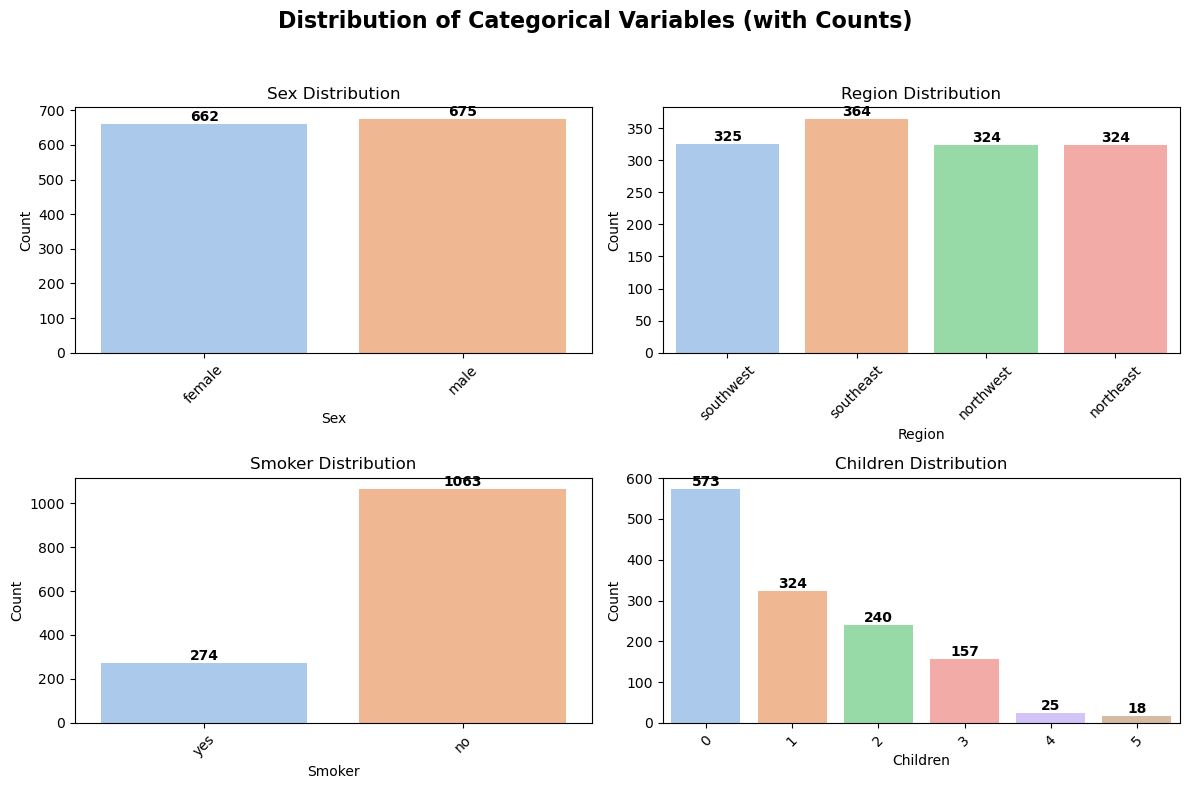

In [23]:
#evaluate categorical variables
# Define categorical columns
categorical_cols = ['sex', 'region', 'smoker', 'children']

# Set up figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribution of Categorical Variables (with Counts)", fontsize=16, fontweight='bold')

# Loop through columns and axes
for ax, col in zip(axes.flat, categorical_cols):
    # Create barplot
    plot = sns.countplot(x=col, data=df, palette='pastel', ax=ax)

    # Add counts on top of each bar
    for p in plot.patches:
        height = p.get_height()
        plot.annotate(f'{int(height)}', 
                      (p.get_x() + p.get_width() / 2, height),
                      ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### In the above bar charts it looks like for the categorical variables sex and region there is a roughly even split between each of the categories. Smoker distribution looks like there is a larger quantiy of the sample that are non-smokers. Similarly, for most individuals in the sample they have no children with the number of children per participant reducing as the number of children increases.

<Axes: >

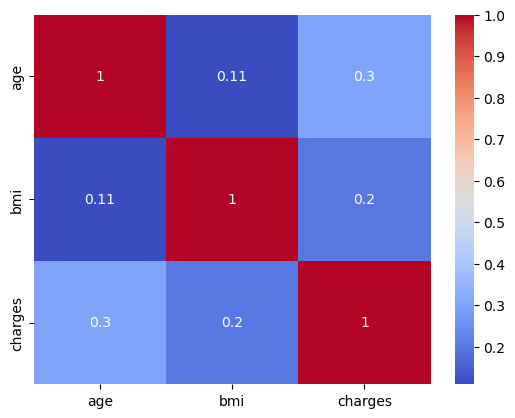

In [27]:
# Looking at the correlations between variables
numerical_cols = ['age', 'bmi','charges']
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap = 'coolwarm')

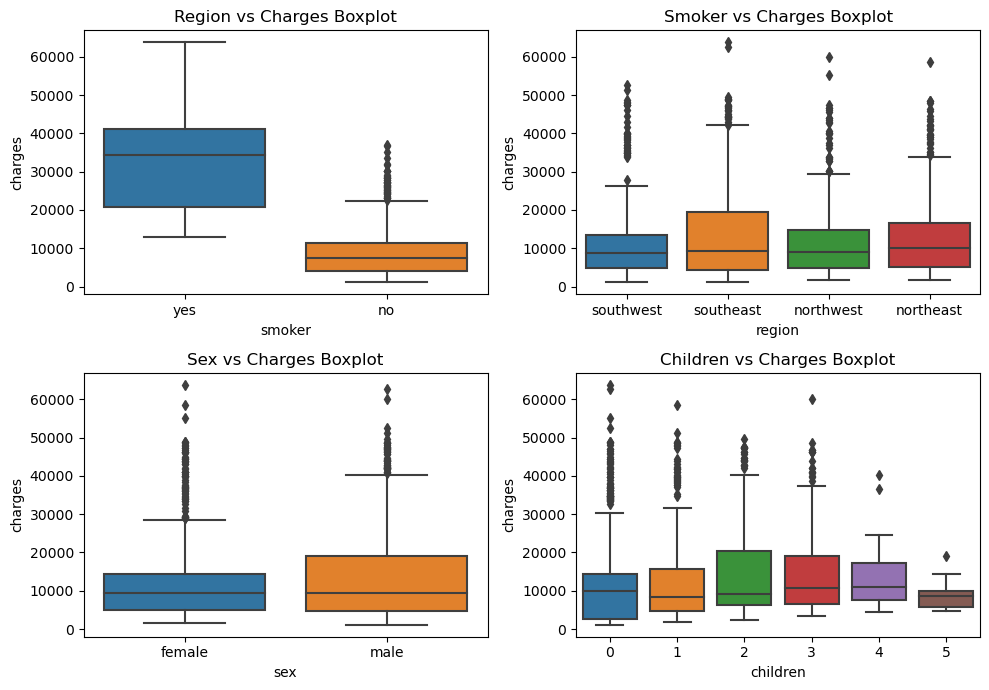

In [31]:
#Handling categorical variables

fig = plt.figure(figsize=(10, 7))

plt.subplot(2,2,1)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Region vs Charges Boxplot')

plt.subplot(2,2,2)
sns.boxplot(x='region', y='charges', data=df)
plt.title('Smoker vs Charges Boxplot')

plt.subplot(2,2,3)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Sex vs Charges Boxplot')

plt.subplot(2,2,4)
sns.boxplot(x='children', y='charges', data=df)
plt.title('Children vs Charges Boxplot')

plt.tight_layout()
plt.show()

In [ ]:
#discuss the output of the boxplots

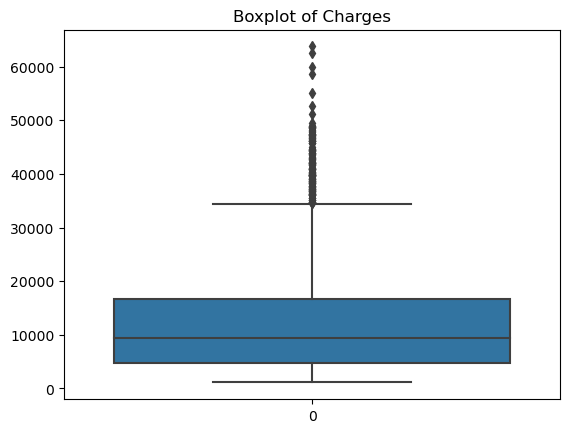

In [35]:
#Checking for outliers in the target variable before moving on to building the model
plt.title('Boxplot of Charges')
sns.boxplot(df['charges'])
plt.show()

In [37]:
# It looks like there is indeed some outliers in this target variable. Using Z-score to remove these outliers
z = np.abs(stats.zscore(df['charges']))
print(z)

0       0.297857
1       0.954381
2       0.729373
3       0.719104
4       0.777499
          ...   
1333    0.221263
1334    0.914695
1335    0.962287
1336    0.931054
1337    1.310298
Name: charges, Length: 1337, dtype: float64


In [40]:
#Now that we have z scores for each data point in the charges column we can remove any with a score > 3
threshold_z = 3

outlier_indices = np.where(z > threshold_z)[0]
df_no_outliers = df.drop(outlier_indices)
print("Original DataFrame Shape:", df.shape)
print("DataFrame Shape after Removing Outliers:", df_no_outliers.shape)

Original DataFrame Shape: (1337, 7)
DataFrame Shape after Removing Outliers: (1330, 7)


#### Seven rows of the sample have been removed as they are outliers

### Model Creation

In [48]:
#Before training a model, first I need to change the categorical variables to have number encoding

# Example: binary variables
df_no_outliers['sex'] = df_no_outliers['sex'].map({'male':0, 'female':1})
df_no_outliers['smoker'] = df_no_outliers['smoker'].map({'no':0, 'yes':1})
df_no_outliers['region'] = df_no_outliers['region'].map({'southeast':0,'southwest':1,'northeast':3,'northwest':4})
df_no_outliers.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,1,16884.92400
1,18,0,33.770,1,0,0,1725.55230
2,28,0,33.000,3,0,0,4449.46200
3,33,0,22.705,0,0,4,21984.47061
4,32,0,28.880,0,0,4,3866.85520


C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x500 with 0 Axes>

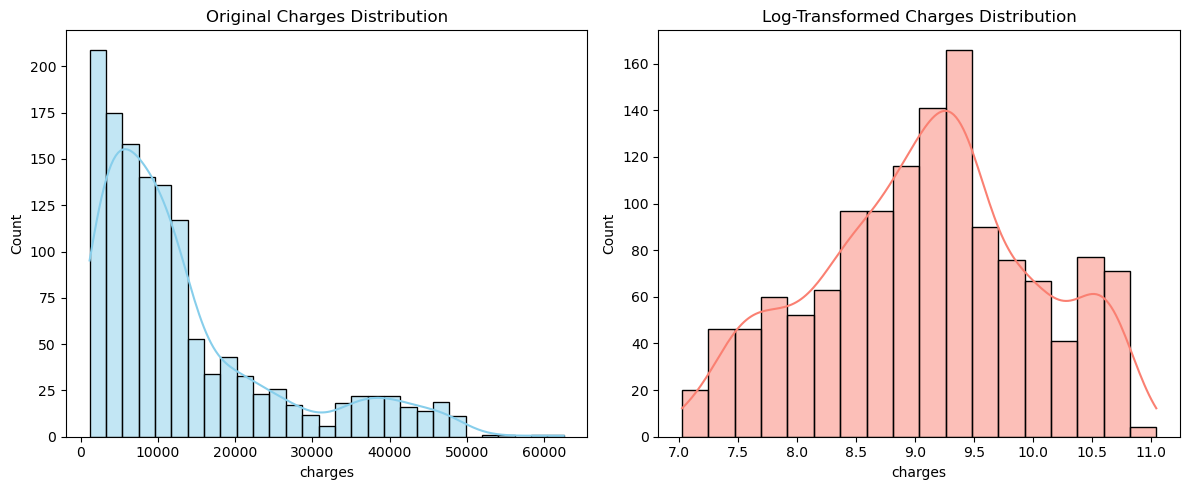

In [53]:
# In the above histograms we seen that the target variabels charges does not have a normal distribution - remedying this:

# Creating a histogram of charges vs log transformed charges to identify any skewness
plt.figure(figsize=(12,5))

# Create 1 row, 2 columns of plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Histogram of original price
sns.histplot(df_no_outliers['charges'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original Charges Distribution')

# Histogram of log-transformed price
sns.histplot(np.log(df_no_outliers['charges']), kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log-Transformed Charges Distribution')

plt.tight_layout()
plt.show()

In [54]:
#### the log transformed distribution looks to be more normalised so we will move forward with this as the target
df_no_outliers['ln_charges'] = np.log1p(df_no_outliers['charges'])
df_no_outliers.head()

,age,sex,bmi,children,smoker,region,charges,ln_charges
0,19,1,27.900,0,1,1,16884.92400,9.734236
1,18,0,33.770,1,0,0,1725.55230,7.453882
2,28,0,33.000,3,0,0,4449.46200,8.400763
3,33,0,22.705,0,0,4,21984.47061,9.998137
4,32,0,28.880,0,0,4,3866.85520,8.260455


In [64]:
#Before training the model creating a function to calculate model accuracy
#evaluting accuracy - MAE = average absolute error (smaller = better) // RMSE = penalizes large errors (smaller = better)
# // R² → proportion of variance explained (closer to 1 = better)
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

### Baseline linear regression

In [57]:
#setting up training and testing splits

X = df_no_outliers.drop(columns = ['charges', 'ln_charges'], axis = 1)
y = df_no_outliers['ln_charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [65]:
#train baseline linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

#make predictions on test set
lr_pred = lr.predict(X_test)

#evaluate baseline model
evaluate_model(y_test, lr_pred)

MAE: 0.255
RMSE: 0.432
R²: 0.752


### Random forest Regressor

In [106]:
#set up parameters
rf = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20, 
    random_state=7, 
    n_jobs=-1
)

#fit model
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#evalaute model
evaluate_model(y_test, y_pred_rf)

MAE: 0.213
RMSE: 0.410
R²: 0.777


In [112]:
#fine tuning the RF regressor to improve results
rf_opt = RandomForestRegressor(random_state=7)

#setting up parameter values to run through
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'auto']
}

#search parameter options
rf_search = RandomizedSearchCV(
    estimator=rf_opt,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=7
)

#fit model and return best parameters
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF RMSE:", -rf_search.best_score_)

C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "C:\Users\xeb15154\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_param

Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best RF RMSE: 0.3759904156691165


In [113]:
#Now using the optimized parameters for a new model
best_rf = rf_search.best_estimator_

y_pred_rf_opt = best_rf.predict(X_test)

#evaluate model
evaluate_model(y_test, y_pred_rf_opt)

MAE: 0.210
RMSE: 0.390
R²: 0.798


### XGBoost Regressor

In [116]:
#set up parameters
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7,
    n_jobs=-1
)

#fit the model
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#evaluate the model
evaluate_model(y_test, y_pred_xgb)

MAE: 0.239
RMSE: 0.433
R²: 0.751


In [117]:
# Optimising the XGBoost regressor
xgb_opt = XGBRegressor(random_state=7)

param_dist = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 3]
}

xgb_search = RandomizedSearchCV(
    xgb_opt,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=7
)

xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB RMSE:", -xgb_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGB params: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best XGB RMSE: 0.3645289632374038


In [118]:
#applying the optimised parameters in a model to predicted the test set
best_xgb = xgb_search.best_estimator_
y_pred_xgb_opt = best_xgb.predict(X_test)

#evalaute model
evaluate_model(y_test, y_pred_xgb_opt)

MAE: 0.193
RMSE: 0.382
R²: 0.806


In [135]:
X_test.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'actual_claim',
       'predicted_claim', 'final_premium'],
      dtype='object')

### LGBMRegressor

In [119]:
#setting parameters
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7
)

#fit model
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

#evalaute model
evaluate_model(y_test, y_pred_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1064, number of used features: 6
[LightGBM] [Info] Start training from score 9.089122
MAE: 0.236
RMSE: 0.418
R²: 0.768


In [120]:
#optimising LGBRegressor
lgb_opt = LGBMRegressor(random_state=7)

#set parameters
param_grid = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

#search parameters
lgb_search = RandomizedSearchCV(
    lgb_opt,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=7
)

#fit
lgb_search.fit(X_train, y_train)
print("Best LGBM params:", lgb_search.best_params_)
print("Best LGBM RMSE:", -lgb_search.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1064, number of used features: 6
[LightGBM] [Info] Start training from score 9.089122
Best LGBM params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best LGBM RMSE: 0.37033315947035933


In [123]:
#applying the optimised parameters in a model to predicted the test set
best_lgb = lgb_search.best_estimator_
y_pred_lgb_opt = best_lgb.predict(X_test)

#evaluating model
evaluate_model(y_test, y_pred_lgb_opt)

MAE: 0.212
RMSE: 0.392
R²: 0.796


### Comparing Model Performance

In [124]:
#creating a list of each models output
models = {
    "Linear Regression": lr_pred,
    "Random Forest": y_pred_rf,
    "Random Forest Optimized": y_pred_rf_opt,
    "XGBoost": y_pred_xgb,
    "XGBoost Optimized": y_pred_xgb_opt,
    "LightGBM": y_pred_lgb,
    "LightGBM Optimized": y_pred_lgb_opt
}

In [125]:
# Collect metrics
results = []
for name, preds in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2})

df_model_results = pd.DataFrame(results).sort_values("RMSE")
display(df_model_results)

,Model,RMSE,MAE,R²
4,XGBoost Optimized,0.381947,0.193193,0.806202
2,Random Forest Optimized,0.390173,0.209732,0.797763
6,LightGBM Optimized,0.392174,0.212499,0.795684
1,Random Forest,0.410078,0.212609,0.776603
5,LightGBM,0.417894,0.235747,0.768006
0,Linear Regression,0.432469,0.254829,0.751542
3,XGBoost,0.432535,0.238707,0.751465


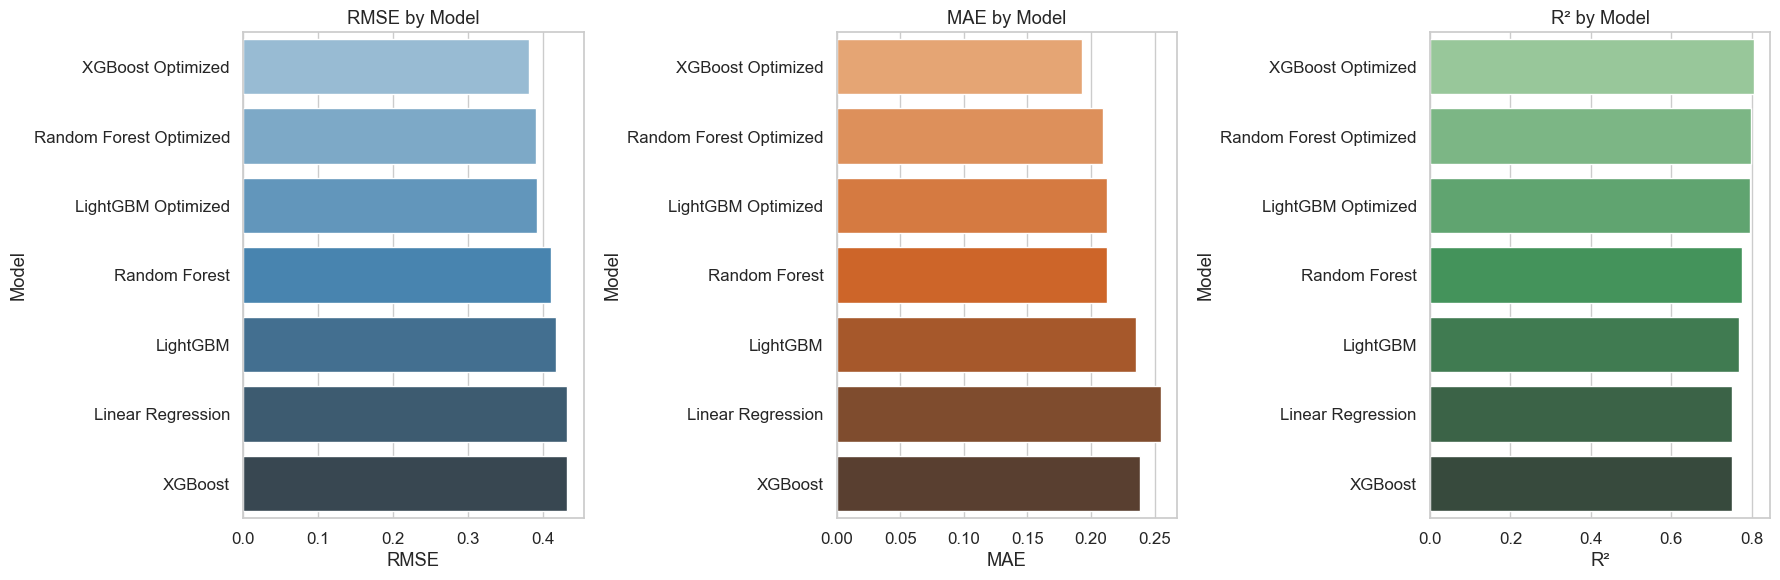

In [127]:
#Plotting results
df_results_rounded = df_model_results.round(4)

# Set style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
sns.barplot(x="RMSE", y="Model", data=df_results_rounded, ax=axes[0], palette="Blues_d")
axes[0].set_title("RMSE by Model")

# MAE
sns.barplot(x="MAE", y="Model", data=df_results_rounded, ax=axes[1], palette="Oranges_d")
axes[1].set_title("MAE by Model")

# R2
sns.barplot(x="R²", y="Model", data=df_results_rounded, ax=axes[2], palette="Greens_d")
axes[2].set_title("R² by Model")

plt.tight_layout()
plt.show()

#### From the analysis it looks like XGBoost is the best model. Therefore, I will use this going forward.

### Evaluating each of the tree based learners to see what drives model predictions to provide some explainability

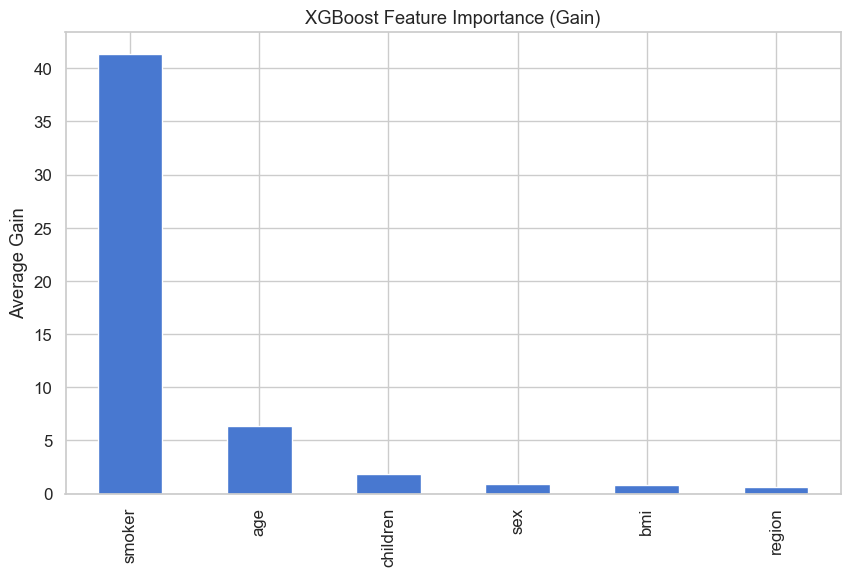

In [129]:
# Get variable importance for each variable in the XGBoost regrossr
importance = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to Series and sort
importance_series = pd.Series(importance).sort_values(ascending=False)

# Plot
importance_series.plot(kind='bar', figsize=(10,6), title='XGBoost Feature Importance (Gain)')
plt.ylabel('Average Gain')
plt.show()

### Calculating final premiums

In [77]:
#Creating a rough guide to calculating premiums. I know this calculation will be more complex but for this study I will just use
# a novel framework to define premium as predicted clain + some variables.

def calculate_premium(predicted_claim, expense=0.10, risk=0.05, profit=0.08, inflation=0.03):
    loadings = 1 + expense + risk + profit + inflation
    return predicted_claim * loadings

In [130]:
#reverting the log transformed predictions made by the model into origonal format
y_pred_original = np.expm1(y_pred_xgb_opt)
y_test_original = np.expm1(y_test)

In [131]:
#calculating final premiums and adding to a dataframe
final_premiums = [calculate_premium(p) for p in y_pred_original]

df_results = X_test
df_results['actual_claim'] = y_test_original
df_results['predicted_claim'] = y_pred_original
df_results['final_premium'] = final_premiums
df_results.head()

,age,sex,bmi,children,smoker,region,actual_claim,predicted_claim,final_premium
52,48,0,28.00,1,1,1,23568.27200,23107.669922,29115.664102
286,46,1,48.07,2,0,3,9432.92530,10162.126953,12804.279961
531,62,1,31.73,0,0,3,14043.47670,13959.926758,17589.507715
932,46,0,25.80,5,0,1,10096.97000,9012.886719,11356.237266
573,62,1,36.86,1,0,3,31620.00106,14784.542969,18628.524141


### Saving the model

In [133]:
#Based on the above analysis the XGBoost optimised model peforms the best across all three metrics. I will save this model and
#use it for the prediction app.
filename = 'Health_insurance_model.pk1'
joblib.dump(best_xgb, filename)

['Health_insurance_model.pk1']